In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline 

Specify parameters of a synthetic diffusion experiment.

In [2]:
#evals = np.array([1.5e-9, 0.4e-9]) # m^2/s
#tensorEigenvalues = np.tile(evals, (2, 1))
D0 = 2.5e-9 # m^2/s
tensorEigenvalues = D0 * np.array([[1, 0.1], [0.1, 0.01]]) # m^2/s

smallDelta = 12.9e-3 # s
bigDelta = 21.8e-3 # s
t_d = bigDelta - smallDelta/3

b_max = 1e10 # s/m^2
q_max = np.sqrt(b_max / t_d) # rad*m^-1
print(2*np.pi/q_max)
print(np.exp(-np.min(tensorEigenvalues)*q_max ** 2 * t_d))

8.31187288207e-06
0.778800783071


Thus we see that these settings mean that $\lambda = \frac{2\pi}{|q|}$ is on the order of a micrometer and that this is high enough that the signal is essentially zero at the highest q-values.

In [3]:
def get_cartesian_grid(num_each_axis=100, scale=1.):
    v, dv = np.linspace(-1, 1, num=num_each_axis, retstep=True)
    x, y = np.meshgrid(v, v)
    vecs = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    return scale * vecs, scale * dv

def normalize(vecs):
    norms = np.linalg.norm(vecs, axis=1)
    norms = norms[:, np.newaxis]
    not_origin = [not np.isclose(norm, 0.) for norm in norms]
    vecs[np.nonzero(not_origin), :] /= norms[np.nonzero(not_origin)]
    return vecs, norms

def get_cartesian_unit_vectors_and_norms(num_each_axis = 100):
    vecs, _ = get_cartesian_grid(num_each_axis=num_each_axis)
    unit_vecs, norms = normalize(vecs)
    return unit_vecs, norms

q_cart, _ = get_cartesian_grid(num_each_axis=5)
unit_vecs, norms = get_cartesian_unit_vectors_and_norms(num_each_axis=5)
assert(np.allclose(q_cart, norms * unit_vecs))

## 2-tensor case in 2D

In [4]:
def rotation_matrix(angle_deg=90):
    theta = np.radians(angle_deg)
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, -s], [s, c]])

class Multi_tensor:
    def __init__(self, evals, angles, fractions):
        self.single_tensors = [Single_tensor(evals[i, :], angles[i]) for i in range(len(angles))]
        self.fractions = fractions / np.sum(fractions)

    def signal(self, t_d, qvecs):
        S = np.zeros((qvecs.shape[0], 1))
        for i in range(len(self.fractions)):
            S += self.fractions[i] * self.single_tensors[i].signal(t_d, qvecs)
        return S

    def propagator(self, t_d, rvecs):
        P = np.zeros((rvecs.shape[0], 1))
        for i in range(len(self.fractions)):
            P += self.fractions[i] * self.single_tensors[i].propagator(t_d, rvecs)
        return P
    
    def analytic_fourier_transform(self, t_d, N, dq):
        FOV = 2*np.pi / dq
        r_max = (N-1)/N * FOV/2
        rvecs, dr = get_cartesian_grid(num_each_axis=N, scale=r_max) 
        P = self.propagator(t_d, rvecs)
        return P, rvecs

class Single_tensor:
    def __init__(self, evals, angle):
        R = rotation_matrix(angle_deg=angle)
        self.D = np.dot(np.dot(R, np.diag(evals)), R.T)

    def signal(self, t_d, qvecs):
        S = np.zeros((qvecs.shape[0], 1))
        for i, q in enumerate(qvecs):
            S[i] = np.exp(-t_d*np.dot(np.dot(q.T, self.D), q))
        return S
    
    def propagator(self, t_d, rvecs):
        P = mvn.pdf(rvecs, cov=2*t_d*self.D)
        return P[:, np.newaxis]

In [21]:
N = 99
qvecs, dq = get_cartesian_grid(num_each_axis=N, scale=q_max)

mt = Multi_tensor(tensorEigenvalues, (70, 130), (90, 10))
S = mt.signal(t_d, qvecs)
S = S.reshape(N, N)

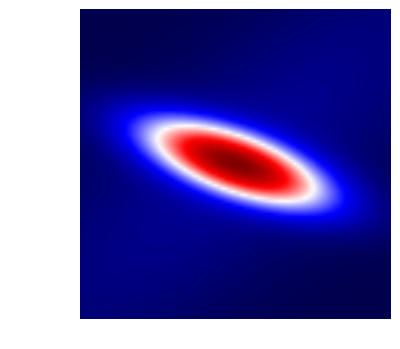

In [22]:
plt.imshow(S, interpolation='bilinear', cmap=cm.seismic,
                origin='lower', extent=[-q_max, q_max, -q_max, q_max],
                vmax=abs(S).max(), vmin=0)

plt.axis('off');

Note that below we cheat with the resolution to get a nice looking figure.

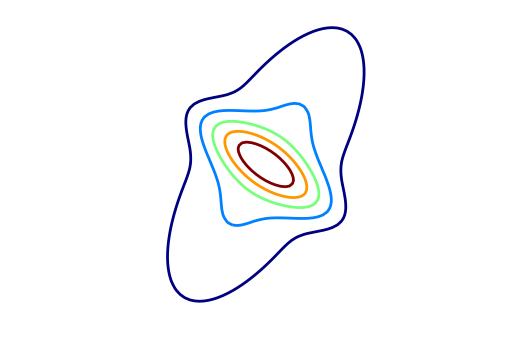

In [28]:
P, rvecs = mt.analytic_fourier_transform(t_d, N, 20*dq)
P = P.reshape(N, N)

levels = np.linspace(0, np.max(P), 7, endpoint=False);
levels = levels[2:]
plt.contour(P, levels, origin='lower', linewidths=2)
plt.axis('off');
plt.savefig('eap_2_tensor.png', transparent=True)

## Retrieve EAP by FFT

In [15]:
b_max_augmented = 5e10 # s/m^2
q_max_augmented = np.sqrt(b_max_augmented / t_d) # rad*m^-1
scale = q_max_augmented / q_max

def upscale_by_zero_padding(S, scale=1.):
    size = np.array(S.shape)
    new_size = round_up_to_odd(scale * size)
    half_size_diff = ((new_size - size)/2).astype(int)
    padded_S = np.pad(S,
                      ((half_size_diff[0], half_size_diff[0]), (half_size_diff[1], half_size_diff[1])),
                      mode='constant',
                      constant_values=0)
    return padded_S

def round_up_to_odd(val):
    return np.ceil(val) // 2 * 2 + 1

def calculate_eap_from_signal(S, **kwargs):
    eap = np.fft.fftshift(np.fft.irfft2(np.fft.ifftshift(S), **kwargs))
    #r = np.fft.
    return eap
    

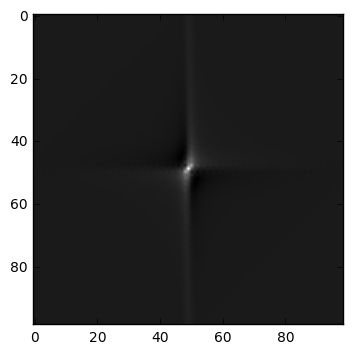

In [29]:
padded_S = upscale_by_zero_padding(S, scale=scale)
eap = calculate_eap_from_signal(padded_S, s=S.shape)
#eap = calculate_eap_from_signal(padded_S)
plt.imshow(eap, cmap=cm.gray)


In [10]:
padded_S.shape

(223, 223)

## Make bar chart comparing performance of GP vs. HYDI

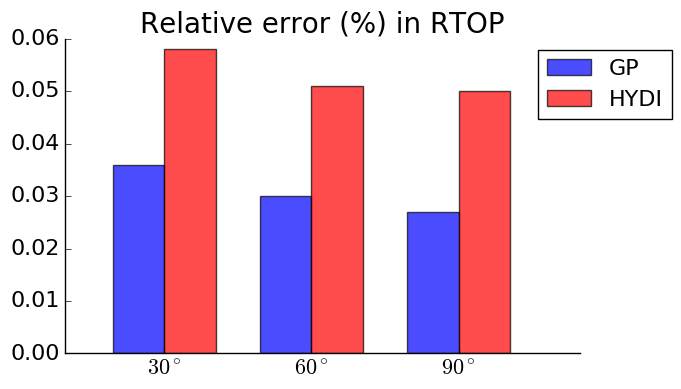

In [70]:
rel_err_GP = (0.036, 0.030, 0.027)
rel_err_HYDI = (0.058, 0.051, 0.050)

n_groups = len(rel_err_GP)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.7

rects1 = plt.bar(index, rel_err_GP, bar_width,
                 alpha=opacity,
                 color='b',
                 align='center',
                 label='GP')

rects2 = plt.bar(index + bar_width, rel_err_HYDI, bar_width,
                 alpha=opacity,
                 color='r',
                 align='center',
                 label='HYDI')

plt.title('Relative error (%) in RTOP', fontsize=20)
plt.xticks(index + bar_width / 2, ('$30^\circ$', '$60^\circ$', '$90^\circ$'),fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.2, 1), fontsize=16)
plt.tight_layout()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig("rtop_error.png", bbox_inches='tight', transparent=True)

## Visualize covariance functions

In [253]:
import GPy
import pandas as pd
import seaborn as sns

In [77]:
def qMagnitudeTransform(qMagnitude):
    return np.log(1 + qMagnitude ** 2)

In [147]:
N=50
b = np.linspace(0, b_max, N)
qMagnitudes = np.sqrt(b / t_d)
#qMagnitudes = np.linspace(0, q_max, N)
qMagnitudes = qMagnitudes.reshape(-1,1)
x = qMagnitudeTransform(qMagnitudes)
kern = GPy.kern.RBF(1, variance=1., lengthscale=1.)

K = kern.K(x)

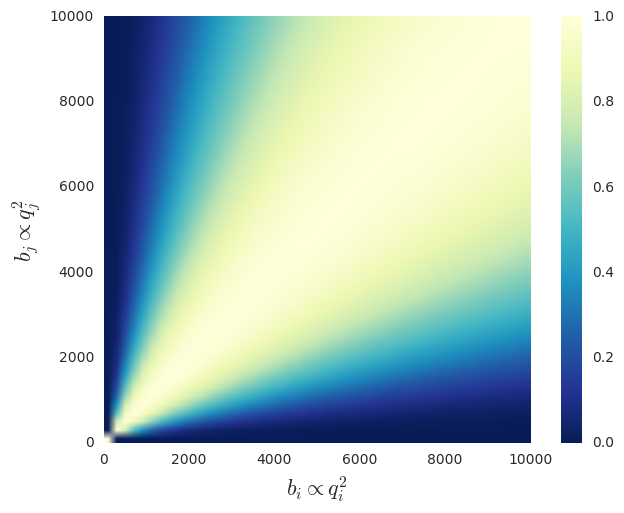

In [190]:
#sns.set_style("dark")
#sns.set_palette(sns.color_palette("BuGn_r"))
levels = (0, 0.2, 0.4, 0.6, 0.8, 1.0)
fig, ax = plt.subplots()
plt.hold(True)
cax = plt.imshow(K, origin='lower', cmap=cm.YlGnBu_r, extent=(0, 10000, 0, 10000))
plt.xlabel('$b_i \propto q_i^2$', fontsize=16)
plt.ylabel('$b_j \propto q_j^2$', fontsize=16)
fig.colorbar(cax, ticks=levels)
plt.savefig("radial_cov.png", bbox_inches='tight', transparent=True)

(-0.60000000000000009, 0.60000000000000009, -1.5, 1.5)

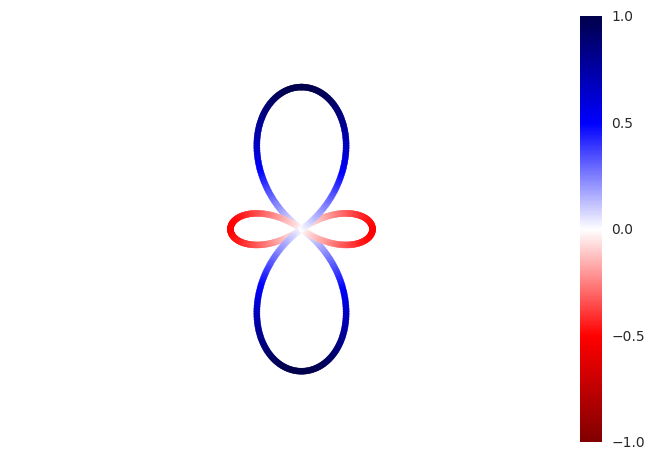

In [296]:
N=500
theta = np.linspace(0, 2 * np.pi, N)
q1 = np.tile(np.array([0, 1]), (N, 1))
q2 = np.array([-np.sin(theta), np.cos(theta)]).T
K_theta = GPy.kern.LegendrePolynomial(input_dim=2, coefficients=[1.], orders=[2])
K = K_theta.K(q1, q2)

k_max = 1.
k_min = -1.

k_1d = K[0, :]
r = np.abs(k_1d[:, np.newaxis])
u = r * q2


k_colors = (k_1d - k_min)/(k_max - k_min)

m = cm.ScalarMappable(cmap=cm.seismic_r)
m.set_array(np.linspace(k_min, k_max, N))

fig, ax = plt.subplots()
cax = plt.scatter(u[:, 0], u[:, 1], color=cm.seismic_r(k_colors))
plt.axis('equal')
plt.colorbar(m, ticks=(-1, -0.5, 0, 0.5, 1))
plt.axis('off')

Nice polar plot background using seaborn here: http://seaborn.pydata.org/examples/facets_with_custom_projection.html
Defer to to later.


In [274]:
X= np.column_stack((r, k_colors[:, None]))
df = pd.DataFrame({'r': X[:, 0], 'k': X[:, 1]})

# Convert the dataframe to long-form or "tidy" format
df = pd.melt(df, id_vars=['r'], var_name='abs_cov', value_name='theta')

# Set up a grid of axes with a polar projection
g = sns.FacetGrid(df, col="k", hue="k",
                  subplot_kws=dict(projection='polar'), size=4.5,
                  sharex=False, sharey=False, despine=False)

# Draw a scatterplot onto each axes in the grid
g.map(plt.scatter, "theta", "r")

KeyError: 'k'